In [46]:
import drawing
import imp
imp.reload(drawing)

<module 'drawing' from '/u/home/lyrebird_code/handwriting_synthesis/drawing.py'>

In [2]:
import numpy as np

import os

import torch

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
print(device)


cuda:2


In [3]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]


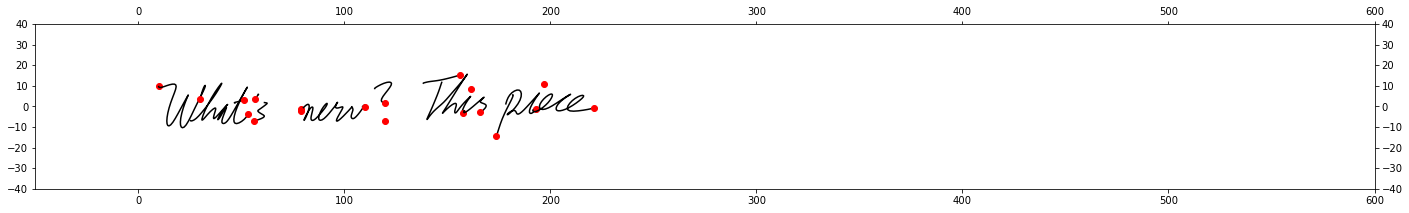

In [4]:
drawing.draw(data[0][0])

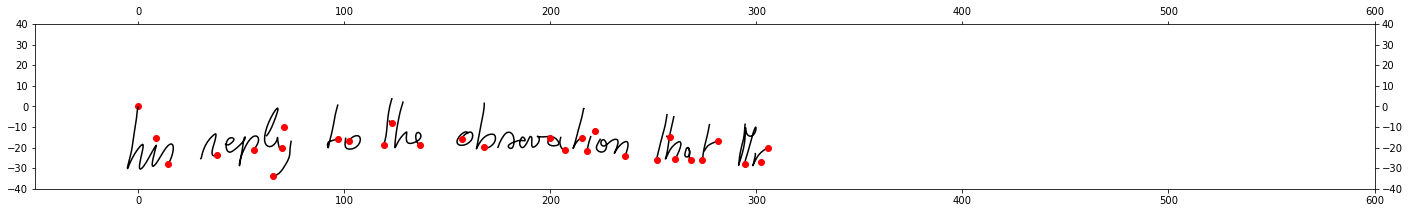

tensor([4099])
802
his reply to the observation that Mr


array([[ 0.        ,  0.        ,  1.        ],
       [-0.12399278, -0.32734093,  0.        ],
       [-0.17111003, -0.66460127,  0.        ],
       [-0.17606975, -0.9597041 ,  0.        ],
       [-0.18102945, -1.3589609 ,  0.        ]], dtype=float32)

In [5]:
index = torch.randint(strokes.shape[0], (1,))
text = drawing.decode_ascii(strings[index])
drawing.draw(strokes[index], align_strokes=False, denoise_strokes=False)
print(index)
print(stroke_lens[index])
print(text)
strokes[index][:5]

In [6]:
import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [7]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes, stroke_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx]
    
train_dataset = HandwritingDataset(strokes[:10000], stroke_lens[:10000])
test_dataset = HandwritingDataset(strokes[10000:], stroke_lens[10000:])

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=1)

In [8]:
next(iter(train_dataloader))[0].shape

torch.Size([1, 1200, 3])

In [9]:
len(train_dataloader)
len(test_dataloader)

10000

1911

n_iter: 0 of 6250, loss: 5.24769921875, timeElapsed: 0.3777289390563965
n_iter: 500 of 6250, loss: 1902.7812705078125, timeElapsed: 177.98896598815918
n_iter: 1000 of 6250, loss: 1353.149822265625, timeElapsed: 355.8735842704773
n_iter: 1500 of 6250, loss: 940.5091271972656, timeElapsed: 536.1023678779602
n_iter: 2000 of 6250, loss: 530.6559940490723, timeElapsed: 715.0625021457672
n_iter: 2500 of 6250, loss: 245.40275823402405, timeElapsed: 894.4145815372467
n_iter: 3000 of 6250, loss: 32.35397386813164, timeElapsed: 1073.9281713962555
n_iter: 3500 of 6250, loss: -154.57734631633758, timeElapsed: 1252.2528088092804
n_iter: 4000 of 6250, loss: -286.5899843158722, timeElapsed: 1431.2485644817352
n_iter: 4500 of 6250, loss: -363.7161818504334, timeElapsed: 1610.6385037899017
n_iter: 5000 of 6250, loss: -407.91266954040526, timeElapsed: 1789.6966035366058
n_iter: 5500 of 6250, loss: -447.7992008361816, timeElapsed: 1967.7764372825623
n_iter: 6000 of 6250, loss: -466.64762519836427, timeEl

<Figure size 432x288 with 0 Axes>

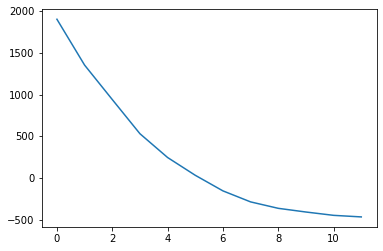

In [11]:
class HandWritingPredictionWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_mixtures):
        super(HandWritingPredictionWithLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_mixtures = num_mixtures
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(3*hidden_size, 6*num_mixtures+1)
        
    def forward(self, inputs, lengths, h0, c0):
        packed_x = pack_padded_sequence(
            inputs,
            lengths.cpu().numpy(),
            batch_first=True)
        packed_out1, _ = self.lstm1(packed_x, (h0, c0))
        out1, _ = pad_packed_sequence(packed_out1, batch_first=True)
        inputs = inputs[:, :out1.shape[1], :]
        packed_inp2 = pack_padded_sequence(
            torch.cat((inputs, out1), -1),
            lengths.cpu().numpy(),
            batch_first=True)
        packed_out2, _ = self.lstm2(packed_inp2, (h0, c0))
        out2, _ = pad_packed_sequence(packed_out2, batch_first=True)

        packed_inp3 = pack_padded_sequence(
            torch.cat((inputs, out2), -1),
            lengths.cpu().numpy(),
            batch_first=True)
        packed_out3, _ = self.lstm3(packed_inp3, (h0, c0))
        out3, _ = pad_packed_sequence(packed_out3, batch_first=True)

        input4 = torch.cat((out1, out2, out3), -1)
        out4 = self.linear(input4)
        return out4

input_size = 3
hidden_size = 500
batch_size = 16
n_mixtures = 20
m = HandWritingPredictionWithLSTM(input_size, hidden_size, n_mixtures).to(device)

def negative_log_likelihood(batch_params, stroke_lengths, batch_targets):  
    batch_loss = 0
    for i in range(len(stroke_lengths)):
        stroke_length = stroke_lengths[i]
        params = batch_params[i][:stroke_length-1]
        targets = batch_targets[i][1:stroke_length]
        
        es = 1/(1 + torch.exp(params[:,-1]))
        pis = nn.Softmax(1)(params[:,0:n_mixtures])
        mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
        sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
        phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

        covs = torch.zeros(stroke_length-1, n_mixtures, 2, 2, device=device)
        tol = torch.tensor(0.000000001, device=device)
        covs[:,:,0,0] = sigmas[:,:,0] ** 2
        covs[:,:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
        covs[:,:,1,0] = covs[:,:,0,1]
        covs[:,:,1,1] = sigmas[:,:,1] ** 2


        distributions = torch.distributions.MultivariateNormal(mus, covs)

        target_coords = targets[:,0:2].unsqueeze(1).repeat_interleave(
            torch.tensor([n_mixtures], device=device), dim=1)
        stroke_lift = targets[:,-1]

        probs = torch.exp(distributions.log_prob(target_coords))
        #probs = torch.where(probs > 10, torch.zeros_like(probs) + 10, probs)
        probs = torch.where(probs < 0.000000001, torch.zeros_like(probs) + 0.000000001, probs)
    #     print(torch.log((pis*probs).sum(dim=1)).sum())
    #     print((torch.log(es)*stroke_lift).sum())
    #     print((torch.log(1 - es)*(1-stroke_lift)).sum())

        batch_loss += - (torch.log((pis*probs).sum(dim=1))).sum() - (torch.log(es)*stroke_lift).sum() - (torch.log(1 - es)*(1-stroke_lift)).sum()
    #print(batch_loss/len(stroke_lengths))
    return batch_loss/len(stroke_lengths)


def train(model, input_strokes, stroke_lengths, optimizer, h0, c0):
    #     print(f"stroke: {input_stroke.shape}")
    #     print(f"stroke_len: {stroke_len}")
    #     print(f"h0: {h0.shape}")
    #     print(f"c0: {c0.shape}")
    optimizer.zero_grad()
    input_strokes.to(device)
    stroke_lengths.to(device)
    
    # prepare for packing
    stroke_lengths_sorted, perm_idx = stroke_lengths.sort(0, descending=True)
    strokes_sorted_by_length = input_strokes[perm_idx]

    outputs = model(strokes_sorted_by_length, stroke_lengths_sorted -1 , h0, c0)

    loss = negative_log_likelihood(
        outputs,
        stroke_lengths_sorted,
        strokes_sorted_by_length
    )
    loss.backward()
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    
    optimizer.step()
    return loss.item()

print_every = 500
n_epochs = 10
n_iters = 0
losses = []
total_loss = 0

optim = torch.optim.Adam(m.parameters(), lr = 0.00001)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

h0=torch.zeros(1, batch_size, hidden_size, device=device)
c0=torch.zeros(1, batch_size, hidden_size, device=device)

import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens,
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_padding.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 6500 of 6250, loss: -505.8184065551758, timeElapsed: 89.61396265029907
n_iter: 7000 of 6250, loss: -529.4838277282715, timeElapsed: 268.40514969825745
n_iter: 7500 of 6250, loss: -562.4875567626954, timeElapsed: 447.33573937416077
n_iter: 8000 of 6250, loss: -583.0712614746094, timeElapsed: 626.3008072376251
n_iter: 8500 of 6250, loss: -602.5050079956055, timeElapsed: 805.3923716545105
n_iter: 9000 of 6250, loss: -625.2581170654297, timeElapsed: 985.172333240509
n_iter: 9500 of 6250, loss: -642.0162487792969, timeElapsed: 1165.1899859905243
n_iter: 10000 of 6250, loss: -656.2877568359374, timeElapsed: 1344.2381432056427
n_iter: 10500 of 6250, loss: -677.2114589233398, timeElapsed: 1523.1813549995422
n_iter: 11000 of 6250, loss: -691.4937955322266, timeElapsed: 1702.3625676631927
n_iter: 11500 of 6250, loss: -714.8592774658204, timeElapsed: 1881.1061730384827
n_iter: 12000 of 6250, loss: -719.6984807128906, timeElapsed: 2059.9825761318207


<Figure size 432x288 with 0 Axes>

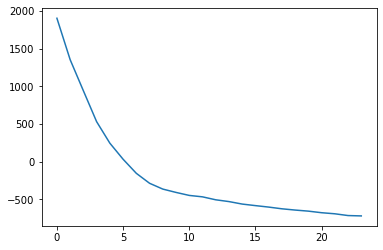

In [12]:
n_epochs = 10
import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens,
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_padding.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 12500 of 4375, loss: -738.1666354370117, timeElapsed: 0.35059404373168945
n_iter: 13000 of 4375, loss: -748.9617996826172, timeElapsed: 179.86119294166565
n_iter: 13500 of 4375, loss: -756.6024872436524, timeElapsed: 359.42376828193665
n_iter: 14000 of 4375, loss: -767.8976287231445, timeElapsed: 538.8364362716675
n_iter: 14500 of 4375, loss: -778.2461853637695, timeElapsed: 718.439975976944
n_iter: 15000 of 4375, loss: -788.0652469482421, timeElapsed: 896.67227602005
n_iter: 15500 of 4375, loss: -793.2050418701172, timeElapsed: 1071.9925734996796
n_iter: 16000 of 4375, loss: -794.6831823730469, timeElapsed: 1249.0075569152832
n_iter: 16500 of 4375, loss: -807.0722313842773, timeElapsed: 1428.987013578415


<Figure size 432x288 with 0 Axes>

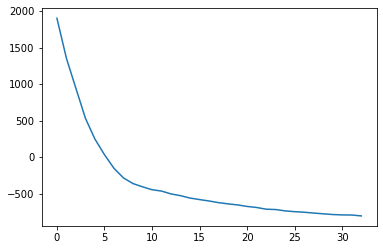

In [13]:
n_epochs = 7
import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens,
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_padding.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 18000 of 4375, loss: -824.0175940551758, timeElapsed: 100.59137797355652
n_iter: 18500 of 4375, loss: -830.3249935913086, timeElapsed: 279.81941866874695
n_iter: 19000 of 4375, loss: -832.641470703125, timeElapsed: 459.27060866355896
n_iter: 19500 of 4375, loss: -834.492244934082, timeElapsed: 638.2618052959442
n_iter: 20000 of 4375, loss: -851.4972506103516, timeElapsed: 818.2650921344757
n_iter: 20500 of 4375, loss: -843.7256203613281, timeElapsed: 997.6630136966705
n_iter: 21000 of 4375, loss: -855.3784816894531, timeElapsed: 1176.3963477611542
n_iter: 21500 of 4375, loss: -856.0623886108399, timeElapsed: 1355.9159197807312
n_iter: 22000 of 4375, loss: -863.3780207519532, timeElapsed: 1535.223780632019


<Figure size 432x288 with 0 Axes>

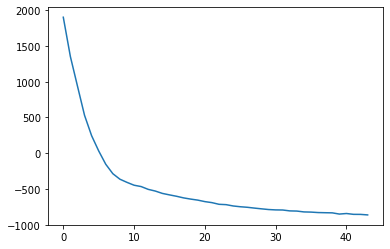

In [49]:
n_epochs = 7
import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens,
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_padding.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

In [50]:
def sample_drawing():
    timestamps = 1200

    with torch.no_grad():
        h1n=torch.zeros(1, 1, hidden_size, device=device)
        c1n=torch.zeros(1, 1, hidden_size, device=device)
        h2n=torch.zeros(1, 1, hidden_size, device=device)
        c2n=torch.zeros(1, 1, hidden_size, device=device)
        h3n=torch.zeros(1, 1, hidden_size, device=device)
        c3n=torch.zeros(1, 1, hidden_size, device=device)
        predictions = torch.zeros(timestamps, 3, device=device)
        predictions[0, 2] = 1
        for i in range(timestamps-1):
            x = predictions[i].unsqueeze(0).unsqueeze(0)
            
            out1, (h1n, c1n) = m.lstm1(x, (h1n, c1n))
            out2, (h2n, c2n) = m.lstm2(torch.cat((x, out1), -1), (h2n, c2n))
            out3, (h3n, c3n) = m.lstm3(torch.cat((x, out2), -1), (h3n, c3n))
            input4 = torch.cat((out1, out2, out3), -1)
            params = m.linear(input4)[0]

            es = 1/(1 + torch.exp(params[:,-1]))
            pis = nn.Softmax(1)(params[:,0:n_mixtures])
            mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
            sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
            phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

            covs = torch.zeros(n_mixtures, 2, 2, device=device)
            tol = torch.tensor(0.000000001, device=device)
            covs[:,0,0] = sigmas[:,:,0] ** 2
            covs[:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
            covs[:,1,0] = covs[:,0,1]
            covs[:,1,1] = sigmas[:,:,1] ** 2

            sample_index = np.random.choice(
                range(n_mixtures),
                p = pis.squeeze().cpu().numpy())

            pen_off = np.random.binomial(1,es.item())

            sample_point = np.random.multivariate_normal(
                mus.squeeze()[sample_index].cpu().numpy(),
                covs[sample_index].cpu().numpy())

            predictions[i+1, 0] = sample_point[0]
            predictions[i+1, 1] = sample_point[1]
            predictions[i+1, 2] = pen_off


    drawing.draw(predictions.cpu(), align_strokes=False, denoise_strokes=False, plot_end_points=False)


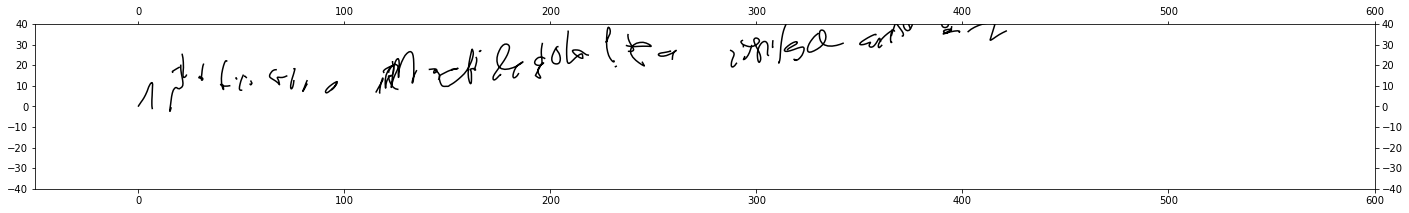

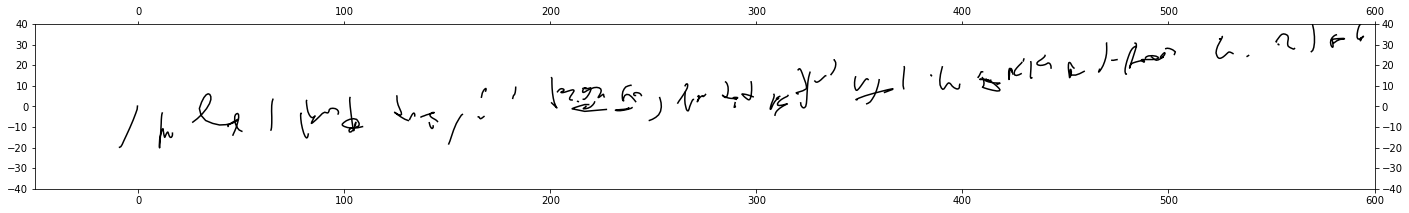

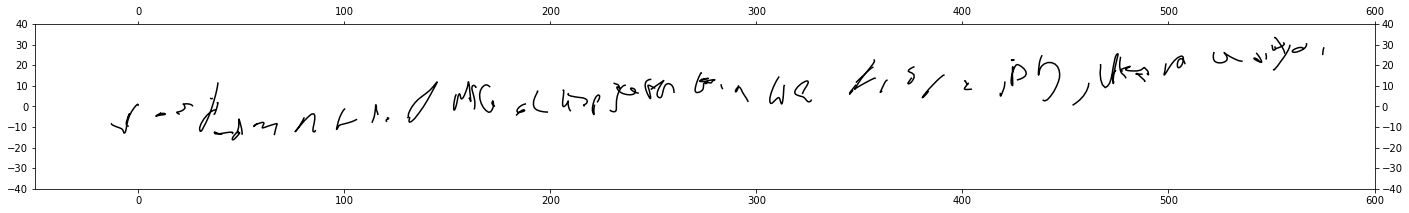

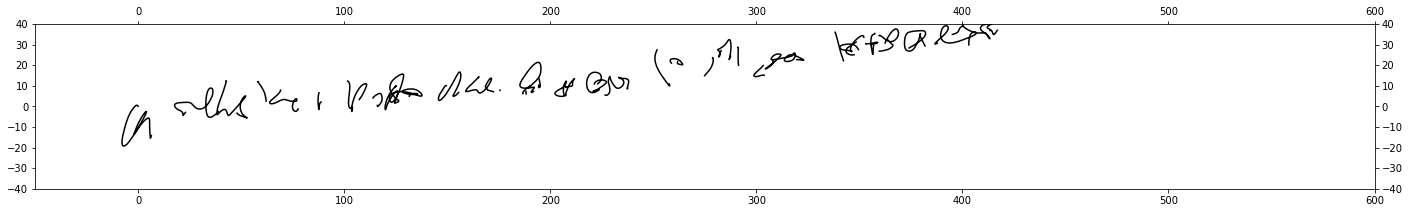

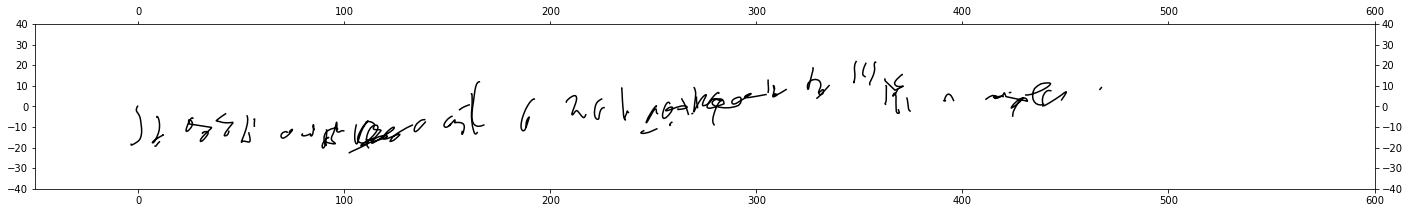

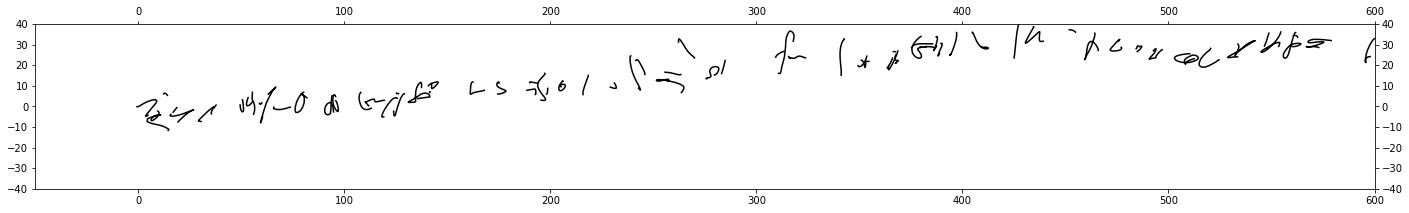

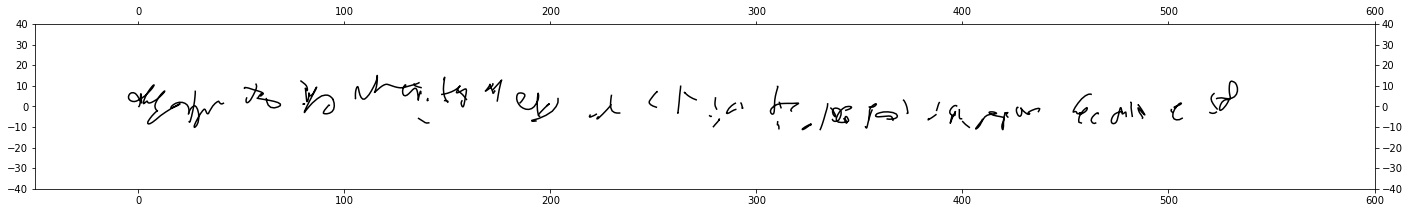

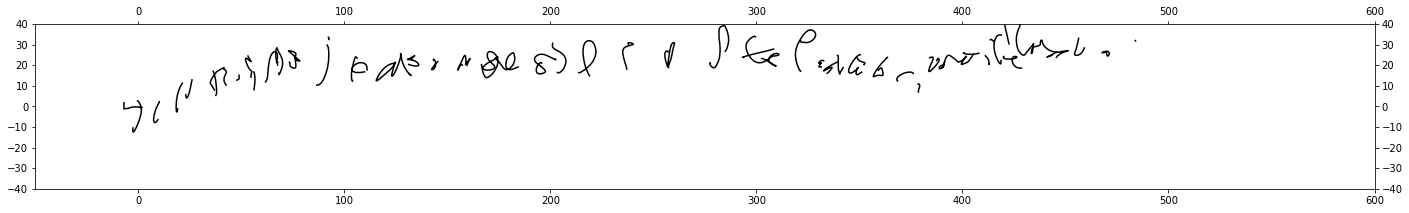

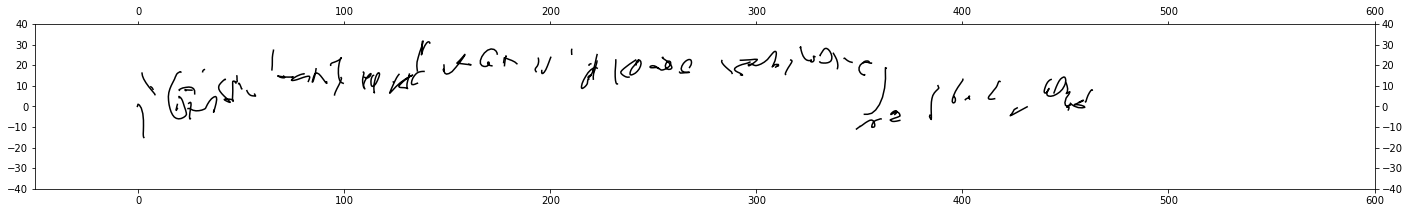

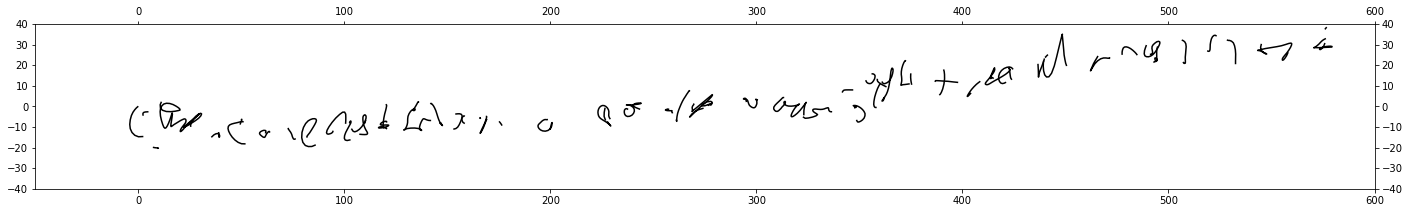

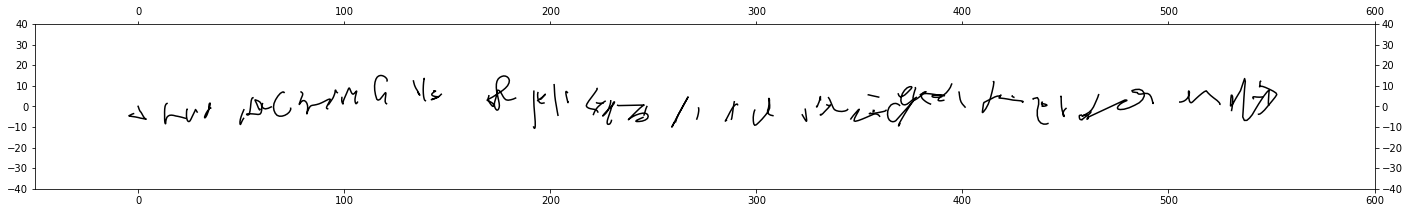

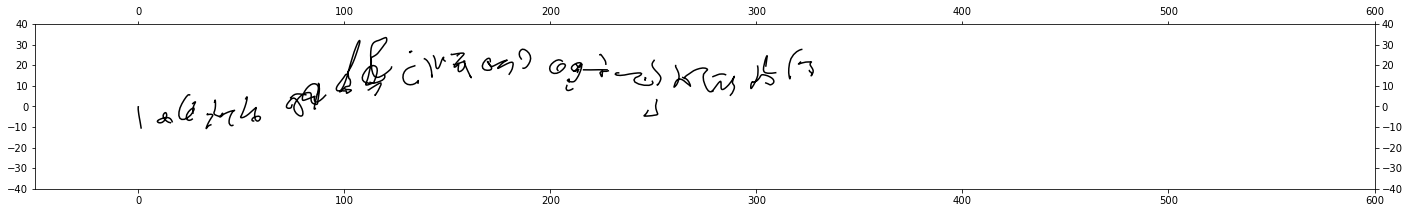

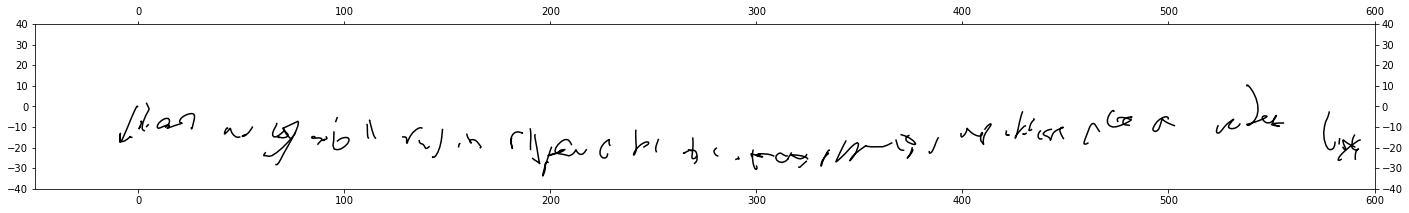

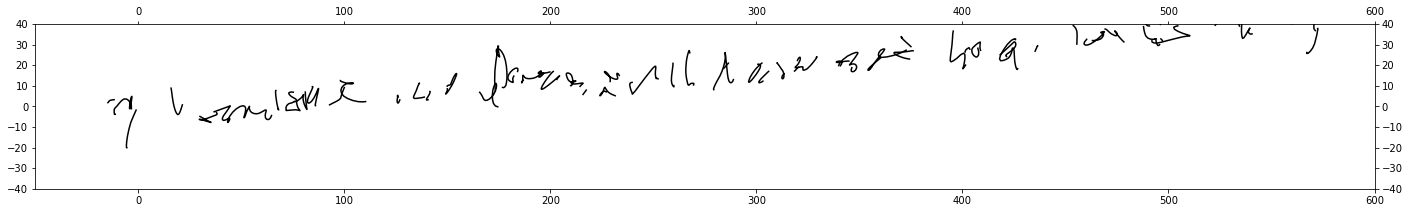

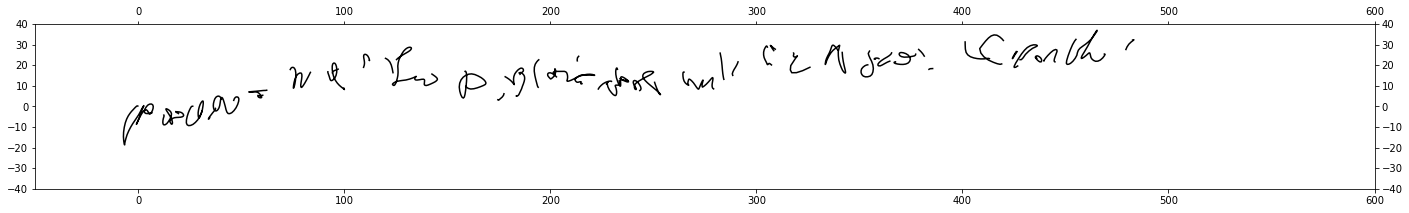

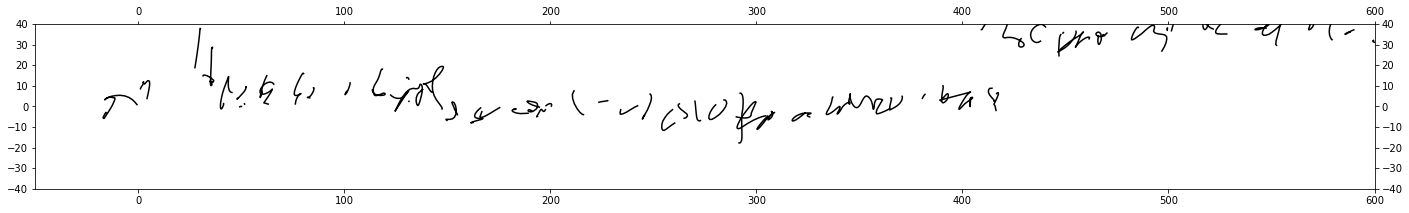

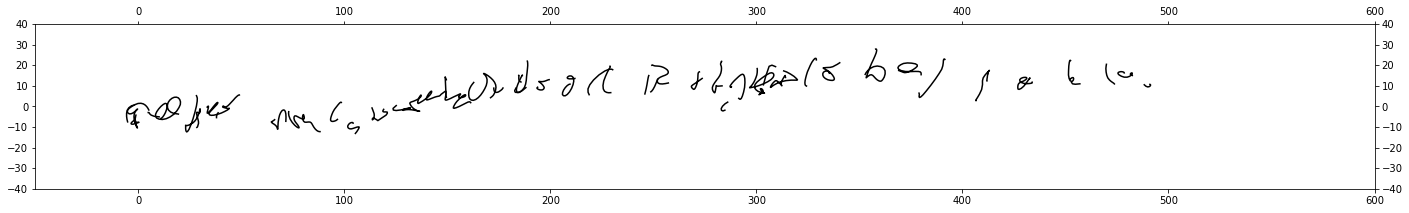

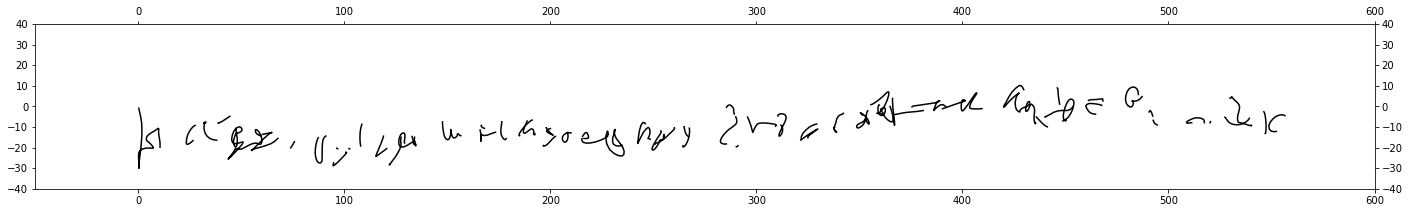

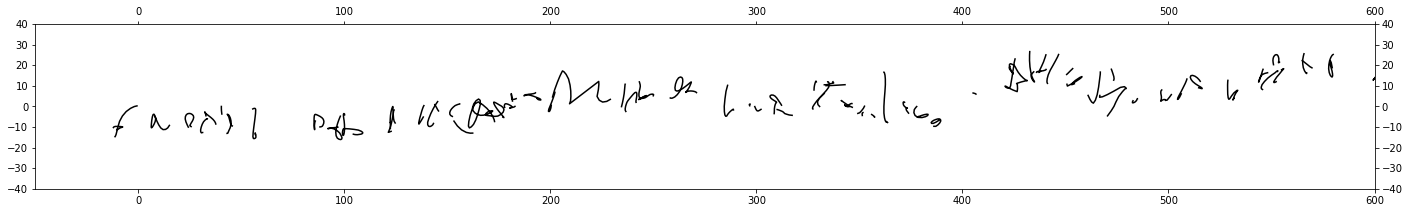

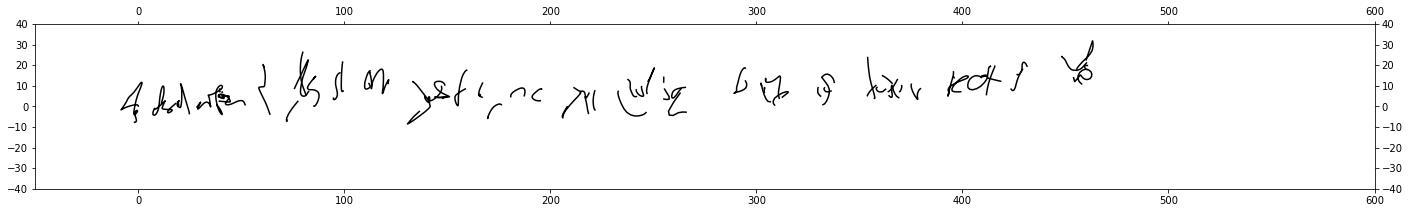

In [51]:
for i in range(20):
    sample_drawing()

n_iter: 22500 of 4375, loss: -864.3271037597656, timeElapsed: 146.87345504760742
n_iter: 23000 of 4375, loss: -874.6805788574219, timeElapsed: 326.18258452415466
n_iter: 23500 of 4375, loss: -876.6286329345703, timeElapsed: 505.77893924713135
n_iter: 24000 of 4375, loss: -879.0949903564454, timeElapsed: 685.5430738925934
n_iter: 24500 of 4375, loss: -887.3768635253906, timeElapsed: 865.1040363311768
n_iter: 25000 of 4375, loss: -884.179810546875, timeElapsed: 1044.1250612735748
n_iter: 25500 of 4375, loss: -897.1061680908203, timeElapsed: 1224.0299060344696


<Figure size 432x288 with 0 Axes>

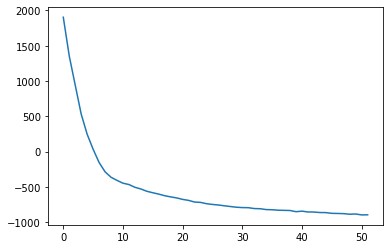

In [52]:
n_epochs = 7
import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens,
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_padding.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

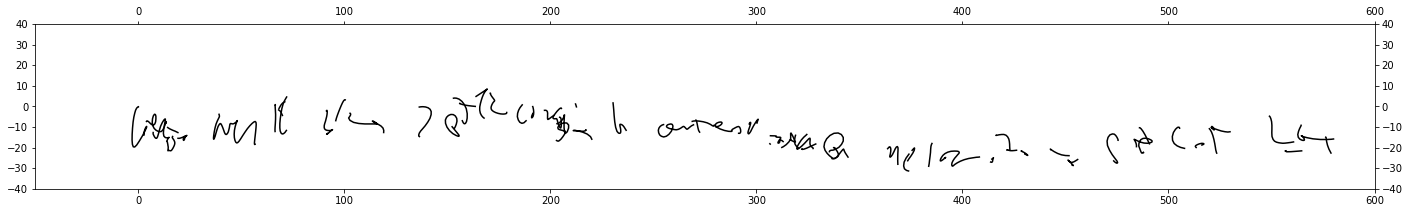

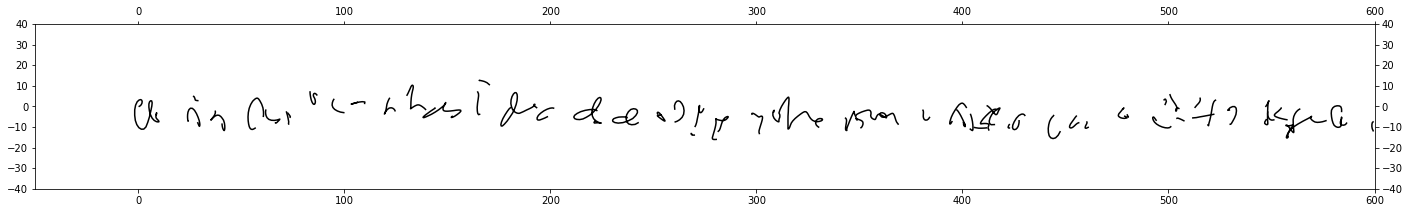

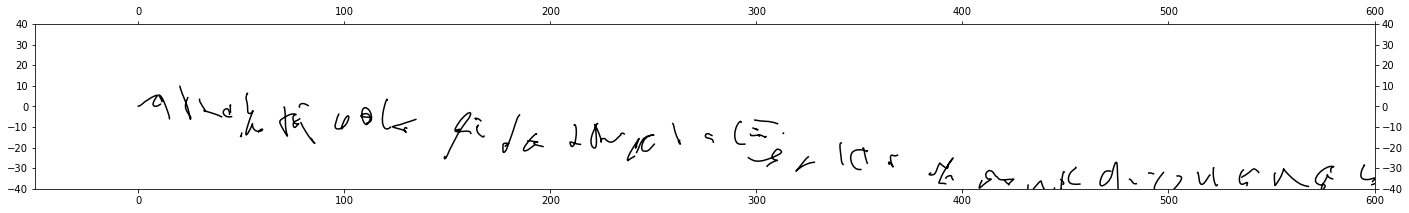

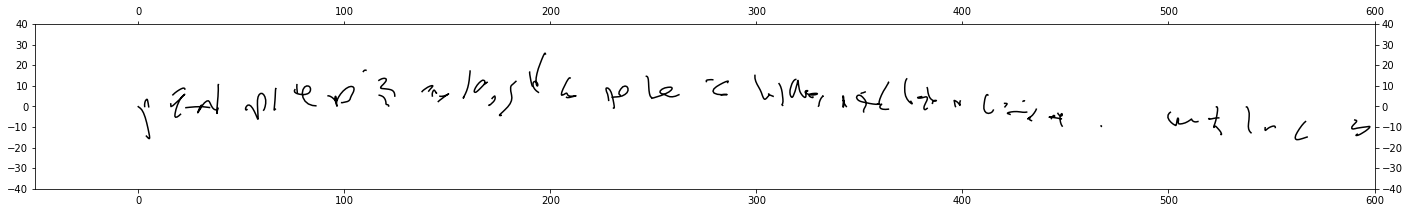

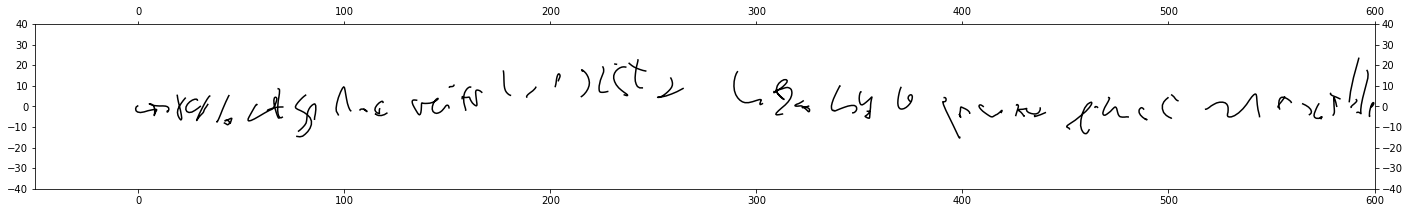

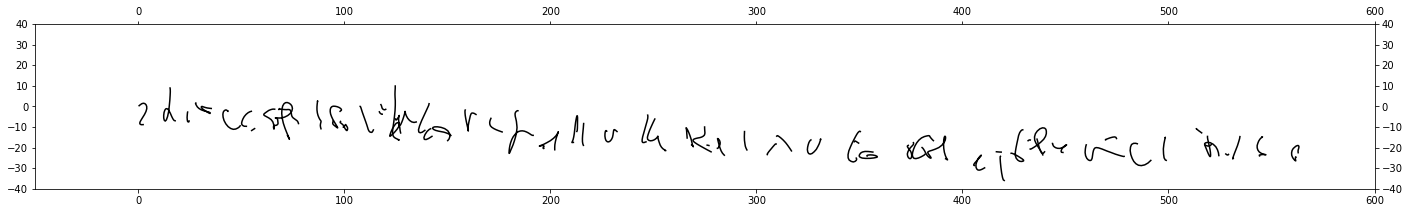

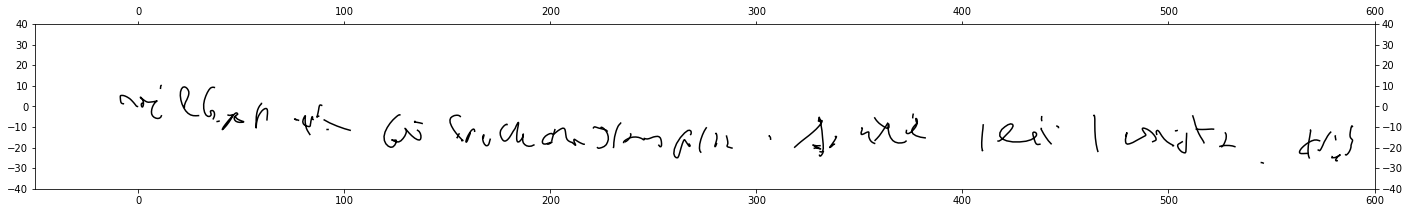

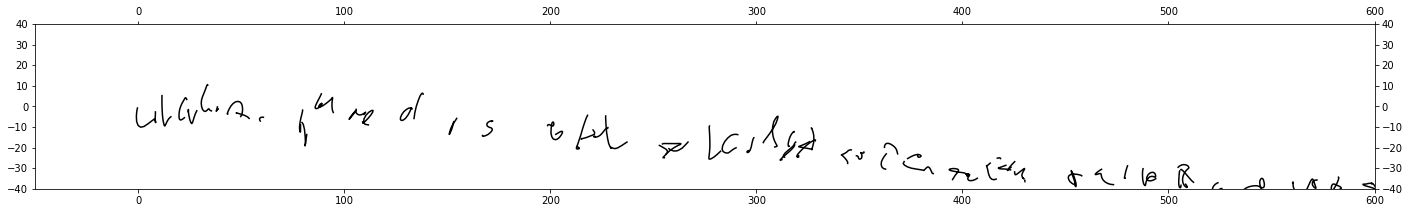

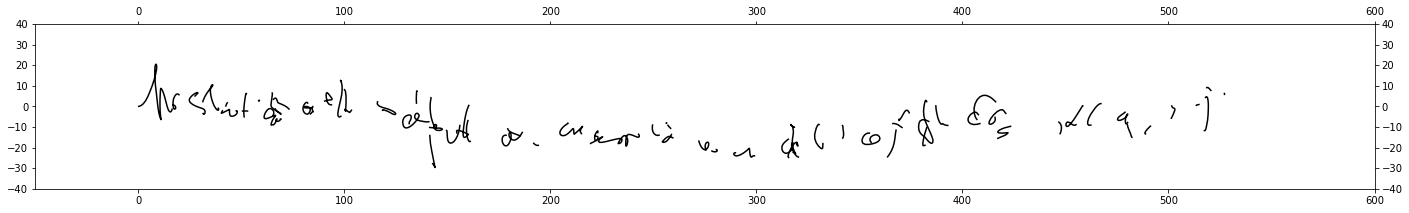

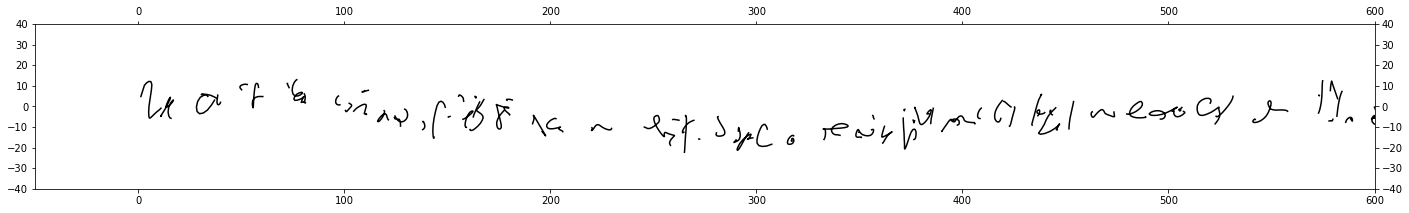

In [53]:
for i in range(10):
    sample_drawing()

n_iter: 0 of 30000, loss: 3.847310302734375, timeElapsed: 0.11220240592956543
n_iter: 500 of 30000, loss: 2004.0821067504883, timeElapsed: 60.391905069351196
n_iter: 1000 of 30000, loss: 1652.998860687256, timeElapsed: 122.22360348701477
n_iter: 1500 of 30000, loss: 1504.8780248413086, timeElapsed: 184.556307554245
n_iter: 2000 of 30000, loss: 1349.756440460205, timeElapsed: 246.48905515670776
n_iter: 2500 of 30000, loss: 1169.17427444458, timeElapsed: 307.89942812919617
n_iter: 3000 of 30000, loss: 1012.6606830291748, timeElapsed: 371.02262020111084
n_iter: 3500 of 30000, loss: 702.095825471878, timeElapsed: 433.24610209465027
n_iter: 4000 of 30000, loss: 546.4414993247985, timeElapsed: 494.79349422454834
n_iter: 4500 of 30000, loss: 436.102669342041, timeElapsed: 556.7463657855988
n_iter: 5000 of 30000, loss: 251.99758296775818, timeElapsed: 618.2831344604492
n_iter: 5500 of 30000, loss: 188.47319030380248, timeElapsed: 679.9425678253174
n_iter: 6000 of 30000, loss: 194.1795405044555

<Figure size 432x288 with 0 Axes>

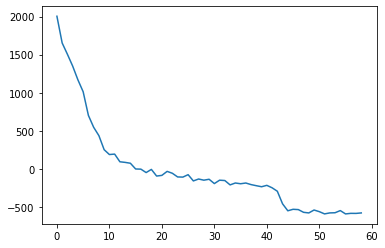

In [23]:
class HandWritingPredictionWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_mixtures):
        super(HandWritingPredictionWithLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_mixtures = num_mixtures
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(3*hidden_size, 6*num_mixtures+1)
        
    def forward(self, x, h0, c0):
        out1, _ = self.lstm1(x, (h0, c0))
        out2, _ = self.lstm2(torch.cat((x, out1), -1), (h0, c0))
        out3, _ = self.lstm3(torch.cat((x, out2), -1), (h0, c0))
        out4 = self.linear(torch.cat((out1, out2, out3), -1).reshape(-1, 3*hidden_size))
        return out4

input_size = 3
hidden_size = 500
batch_size = 1
n_mixtures = 1
m = HandWritingPredictionWithLSTM(input_size, hidden_size, n_mixtures).to(device)

def negative_log_likelihood(params, stroke_length, targets=None):   
    #print(params)
    es = 1/(1 + torch.exp(params[:,-1]))
    pis = nn.Softmax(1)(params[:,0:n_mixtures])
    mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
    sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
    phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

    covs = torch.zeros(stroke_length-1, n_mixtures, 2, 2, device=device)
    tol = torch.tensor(0.000000001, device=device)
    covs[:,:,0,0] = sigmas[:,:,0] ** 2
    covs[:,:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
    covs[:,:,1,0] = covs[:,:,0,1]
    covs[:,:,1,1] = sigmas[:,:,1] ** 2

    
    distributions = torch.distributions.MultivariateNormal(mus, covs)
    
    target_coords = targets[:,0:2].unsqueeze(1).repeat_interleave(
        torch.tensor([n_mixtures], device=device), dim=1)
    stroke_lift = targets[:,-1]
    
    probs = torch.exp(distributions.log_prob(target_coords))
    #probs = torch.where(probs > 10, torch.zeros_like(probs) + 10, probs)
    probs = torch.where(probs < 0.000000001, torch.zeros_like(probs) + 0.000000001, probs)
#     print(torch.log((pis*probs).sum(dim=1)).sum())
#     print((torch.log(es)*stroke_lift).sum())
#     print((torch.log(1 - es)*(1-stroke_lift)).sum())

    loss = - (torch.log((pis*probs).sum(dim=1))).sum() - (torch.log(es)*stroke_lift).sum() - (torch.log(1 - es)*(1-stroke_lift)).sum()
    #print(loss)
    return loss


def train(model, input_stroke, stroke_len, optimizer, h0, c0):
    #     print(f"stroke: {input_stroke.shape}")
    #     print(f"stroke_len: {stroke_len}")
    #     print(f"h0: {h0.shape}")
    #     print(f"c0: {c0.shape}")
    optimizer.zero_grad()
    out = model(input_stroke[:,:stroke_len-1,:], h0, c0)
    loss = negative_log_likelihood(out, stroke_len, input_stroke[:,1:stroke_len,:].squeeze())
    loss.backward()
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    
    optimizer.step()
    return loss.item()

print_every = 500
n_epochs = 3
n_iters = 0
losses = []
total_loss = 0

optim = torch.optim.Adam(m.parameters(), lr = 0.00001)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

h0=torch.zeros(batch_size, 1, hidden_size, device=device)
c0=torch.zeros(batch_size, 1, hidden_size, device=device)
he=torch.zeros(batch_size, 1, input_size, device=device)
ce=torch.zeros(batch_size, 1, input_size, device=device)

import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_stroke=strokes.to(device),
            stroke_len=stroke_lens.item(),
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model2.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

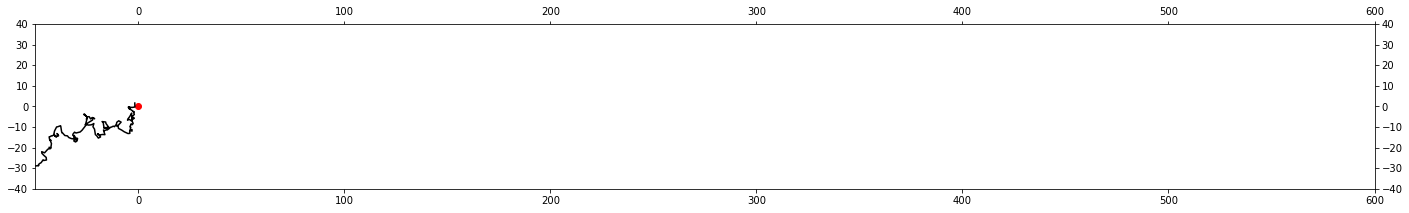

In [53]:
timestamps = 1200

with torch.no_grad():
    h0=torch.zeros(batch_size, 1, hidden_size, device=device)
    c0=torch.zeros(batch_size, 1, hidden_size, device=device)
    predictions = torch.zeros(timestamps, 3, device=device)
    predictions[0, 2] = 1
    for i in range(timestamps-1):
        inp = predictions[i].unsqueeze(0).unsqueeze(1)
        #print(inp.unsqueeze(0).unsqueeze(1))
        #print(h0.shape, c0.shape)
        
        out1, _ = m.lstm1(inp, (h0, c0))
        out2, _ = m.lstm2(torch.cat((inp, out1), -1), (h0, c0))
        out3, _ = m.lstm3(torch.cat((inp, out2), -1), (h0, c0))
        params = m.linear(torch.cat((out1, out2, out3), -1).reshape(-1, 3*hidden_size))

        #print(params)
        es = 1/(1 + torch.exp(params[:,-1]))
        pis = nn.Softmax(1)(params[:,0:n_mixtures])
        mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
        sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
        phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

        covs = torch.zeros(n_mixtures, 2, 2, device=device)
        tol = torch.tensor(0.000000001, device=device)
        covs[:,0,0] = sigmas[:,:,0] ** 2
        covs[:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
        covs[:,1,0] = covs[:,0,1]
        covs[:,1,1] = sigmas[:,:,1] ** 2

        mixtures = torch.distributions.MultivariateNormal(mus, covs)
        sample = mixtures.sample().squeeze()
        predictions[i+1, 0] = sample[0]
        predictions[i+1, 1] = sample[1]
        predictions[i+1, 2] = 0#torch.bernoulli(es).item()

drawing.draw(predictions.cpu(), align_strokes=False, denoise_strokes=False)


In [35]:
a = 10000
b = 0
for i in range(a):
    b += torch.bernoulli(torch.tensor(0.9)).item()
b

8995.0

In [108]:
torch.set_printoptions(precision=10)
mus = torch.rand(22, 20, 2)
mus.shape
sigmas = torch.rand(22, 20, 2)
sigmas.shape
phos = torch.rand(22, 20, 1)
phos.shape
covs = torch.zeros(22, 20, 2, 2)
covs[:,:,0,0] = sigmas[:,:,0]**2
covs[:,:,1,1] = sigmas[:,:,1]**2

distributions = torch.distributions.MultivariateNormal(mus, covs)
print(distributions.batch_shape, distributions.event_shape)
targets = torch.rand(22, 2).unsqueeze(1)
targets = targets.repeat_interleave(torch.tensor([20]), dim=1)
targets.shape
lp = torch.exp(distributions.log_prob(targets))
lp.shape
wts = nn.Softmax(1)(torch.rand(22, 20))
wts.shape
lp[1,:]
wts[1,:]
(wts * lp)[1,:]
(wts * lp).shape

torch.Size([22, 20, 2])

torch.Size([22, 20, 2])

torch.Size([22, 20, 1])

torch.Size([22, 20]) torch.Size([2])


torch.Size([22, 20, 2])

torch.Size([22, 20])

torch.Size([22, 20])

tensor([2.3569624126e-01, 2.1319295466e-01, 3.6014885902e+00, 2.5937536359e-01,
        2.3509171009e+00, 1.8440544605e-01, 4.0873944759e-01, 1.0915555954e+00,
        1.0121872276e-01, 6.5111726522e-02, 3.0681800842e-01, 0.0000000000e+00,
        2.0708531141e-01, 1.6538779438e-01, 3.7418460846e-01, 1.7672851682e-02,
        4.0297690034e-01, 2.0239457954e-03, 1.9792731106e-01, 3.3254542351e+00])

tensor([0.0696100071, 0.0577052049, 0.0398469940, 0.0302223898, 0.0613434203,
        0.0288010295, 0.0389507748, 0.0417387374, 0.0657069981, 0.0568057299,
        0.0511838794, 0.0573577546, 0.0648760572, 0.0627077669, 0.0296213962,
        0.0419256724, 0.0491249934, 0.0397933759, 0.0569694042, 0.0557084493])

tensor([1.6406817362e-02, 1.2302342802e-02, 1.4350849390e-01, 7.8389430419e-03,
        1.4421328902e-01, 5.3110667504e-03, 1.5920717269e-02, 4.5560151339e-02,
        6.6507784650e-03, 3.6987191997e-03, 1.5704136342e-02, 0.0000000000e+00,
        1.3434878550e-02, 1.0371099226e-02, 1.1083870195e-02, 7.4094621232e-04,
        1.9796237350e-02, 8.0539633927e-05, 1.1275800876e-02, 1.8525590003e-01])

torch.Size([22, 20])

In [57]:
a = torch.tensor([[1, 2, 3], [1, 2, 3]])
a.shape
torch.sum(a, 0)
torch.sum(a, 1)

torch.Size([2, 3])

tensor([2, 4, 6])

tensor([6, 6])

In [ ]:
class HandWritingPredictionWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_mixtures):
        super(HandWritingPredictionWithLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_mixtures = num_mixtures
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(3*hidden_size, 6*num_mixtures+1)
        
    def forward(self, x, h0, c0, he, ce):
        out1, _ = self.lstm1(x, (h0, c0))
        out2, _ = self.lstm2(torch.cat((x, out1), -1), (h0, c0))
        out3, _ = self.lstm3(torch.cat((x, out2), -1), (h0, c0))
        out4 = self.linear(torch.cat((out1, out2, out3), -1).reshape(-1, 3*hidden_size))
        return out4
    
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, 1, self.hidden_size), torch.zeros(batch_size, 1, self.hidden_size)

def train(model, input_stroke, stroke_len, optimizer, loss_fnc, h0, c0, he, ce):
    #     print(f"stroke: {input_stroke.shape}")
    #     print(f"stroke_len: {stroke_len}")
    #     print(f"h0: {h0.shape}")
    #     print(f"c0: {c0.shape}")
    optimizer.zero_grad()
    out = model(input_stroke[:,:stroke_len-1,:], h0, c0, he, ce)
    #     print(out.shape)
    #     print(input_stroke[:,:stroke_len-1,:].shape)
    assert(out.shape == input_stroke[:,:stroke_len-1,:].shape)
    loss = loss_fnc(out, input_stroke[:,1:stroke_len,:])
    loss.backward()
    optimizer.step()
    return loss
    
input_size = 3
hidden_size = 500
batch_size = 1
m = HandWritingPredictionWithLSTM(input_size, hidden_size).to(device)
optim = torch.optim.Adam(m.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

# s, l = next(iter(train_dataloader))
# loss = train(
#     model=m,
#     input_stroke=s.squeeze(dim=2).to(device),
#     stroke_len=l.item(),
#     optimizer=optim,
#     loss_fnc=loss_function,
#     h0=torch.zeros(batch_size, 1, hidden_size, device=device),
#     c0=torch.zeros(batch_size, 1, hidden_size, device=device),
#     he=torch.zeros(batch_size, 1, input_size, device=device),
#     ce=torch.zeros(batch_size, 1, input_size, device=device))

# torch.save({
#             'epoch': 2,
#             'model_state_dict': m.state_dict(),
#             'optimizer_state_dict': optim.state_dict(),
#             'loss': loss,
#             }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model.pt")

print_every = 500
n_epochs = 10
n_iters = 0
losses = []
total_loss = 0

h0=torch.zeros(batch_size, 1, hidden_size, device=device)
c0=torch.zeros(batch_size, 1, hidden_size, device=device)
he=torch.zeros(batch_size, 1, input_size, device=device)
ce=torch.zeros(batch_size, 1, input_size, device=device)

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_stroke=strokes.to(device),
            stroke_len=stroke_lens.item(),
            optimizer=optim,
            loss_fnc=loss_function,
            h0=h0, c0=c0, he=he, ce=ce)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

cuda:0
n_iter: 0 of 100000, loss: 0.005060491617769003
n_iter: 500 of 100000, loss: 2.415259599685669
n_iter: 1000 of 100000, loss: 2.262423038482666
n_iter: 1500 of 100000, loss: 2.371595621109009
n_iter: 2000 of 100000, loss: 2.354013681411743
n_iter: 2500 of 100000, loss: 2.2823498249053955
n_iter: 3000 of 100000, loss: 2.38505482673645
n_iter: 3500 of 100000, loss: 2.282252788543701
n_iter: 4000 of 100000, loss: 2.2105233669281006
n_iter: 4500 of 100000, loss: 2.300356864929199
n_iter: 5000 of 100000, loss: 2.3190813064575195
n_iter: 5500 of 100000, loss: 2.31321120262146
n_iter: 6000 of 100000, loss: 2.2912728786468506
n_iter: 6500 of 100000, loss: 2.245999336242676
n_iter: 7000 of 100000, loss: 2.1940739154815674
n_iter: 7500 of 100000, loss: 2.3092567920684814
n_iter: 8000 of 100000, loss: 2.29649019241333
n_iter: 8500 of 100000, loss: 2.299196720123291
n_iter: 9000 of 100000, loss: 2.2537505626678467
n_iter: 9500 of 100000, loss: 2.3710782527923584
n_iter: 10000 of 100000, loss

In [47]:
timestamps = 1200
with torch.no_grad():
    h0=torch.zeros(batch_size, 1, hidden_size, device=device)
    c0=torch.zeros(batch_size, 1, hidden_size, device=device)
    he=torch.zeros(batch_size, 1, input_size, device=device)
    ce=torch.zeros(batch_size, 1, input_size, device=device)
    predictions = torch.zeros(timestamps, 3, device=device)
    predictions[0, 2] = 1
    for i in range(timestamps-1):
        inp = predictions[i]
        #print(inp.unsqueeze(0).unsqueeze(1))
        #print(h0.shape, c0.shape)
        output, (h0, c0) = m.lstm1(inp.unsqueeze(0).unsqueeze(1), (h0, c0))
        #print(output.shape, h0.shape, c0.shape)
        output, (he, ce) = m.lstm_out(h0, (he, ce))
        #print(output.shape, he.shape, ce.shape)
        predictions[i+1] = he.reshape(-1)
    

    
# start = torch.tensor([0, 0, 1], dtype=torch.float32, device=device)
# with torch.no_grad():
#     a = m(start.unsqueeze(0).unsqueeze(1), h0, c0, he, ce)
# print(a.shape)
# #a[:, :, 2] = a[:, :, 2] > 0.0000001
# #a
# a.reshape(-1)
# a

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00],
        [-1.0651e-01, -1.8280e-01,  1.0190e-07],
        [-2.6253e-01, -3.6974e-01, -2.2414e-06],
        ...,
        [ 1.2201e-02,  3.6043e-02,  9.5921e-03],
        [ 2.0965e-02,  3.4605e-02,  2.9063e-04],
        [ 1.1853e-02,  4.5208e-02,  1.2749e-04]], device='cuda:0')

/tmp/ipykernel_326/3247567841.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions_th = torch.tensor(predictions)


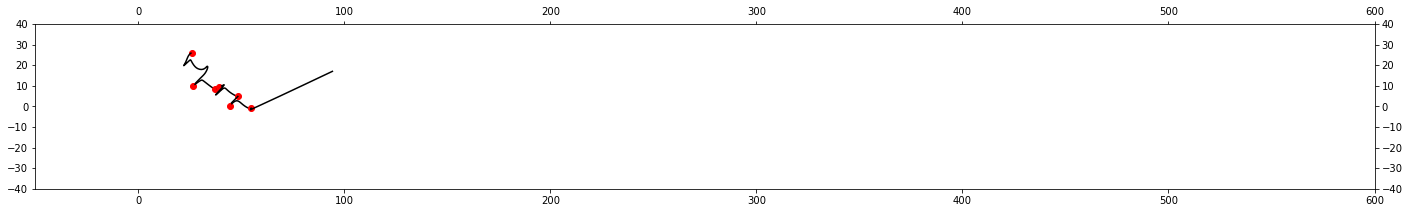

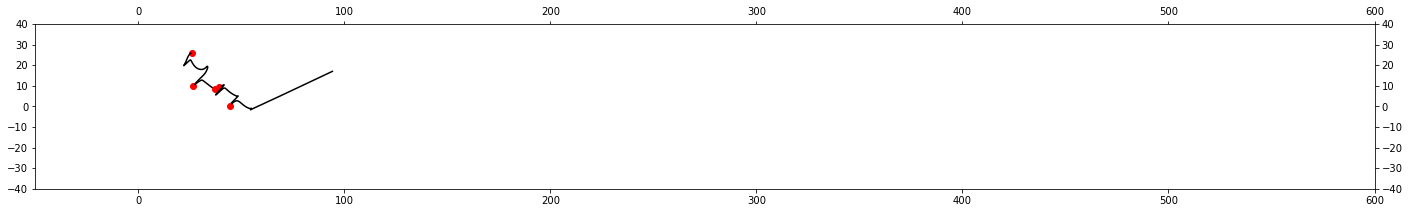

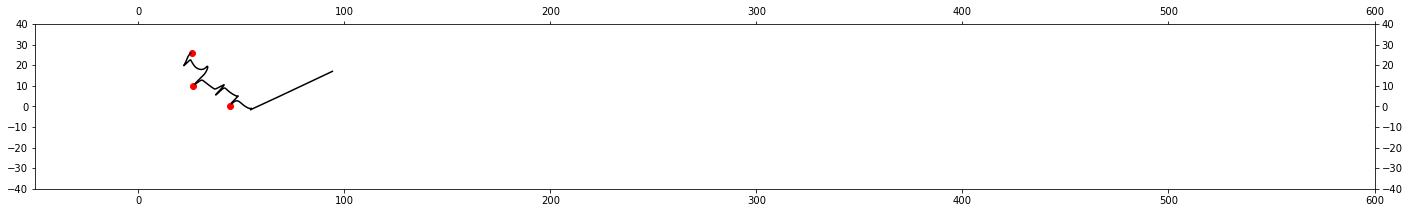

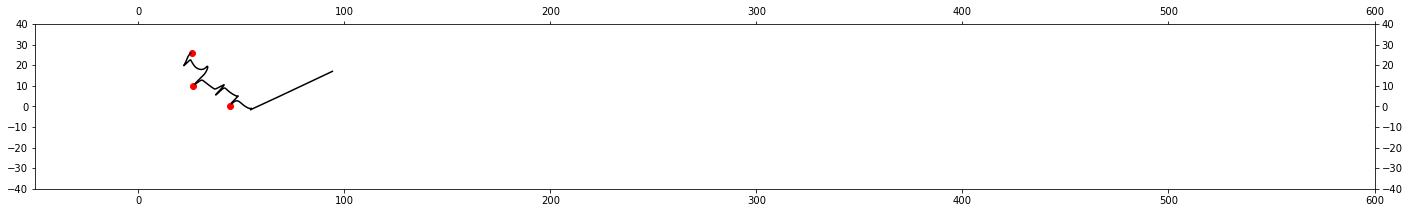

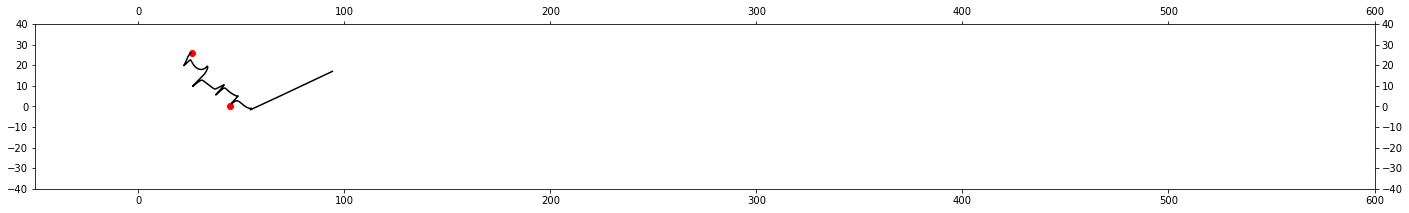

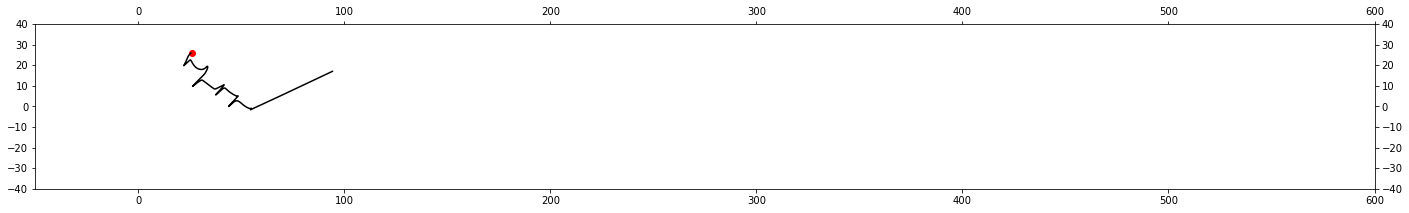

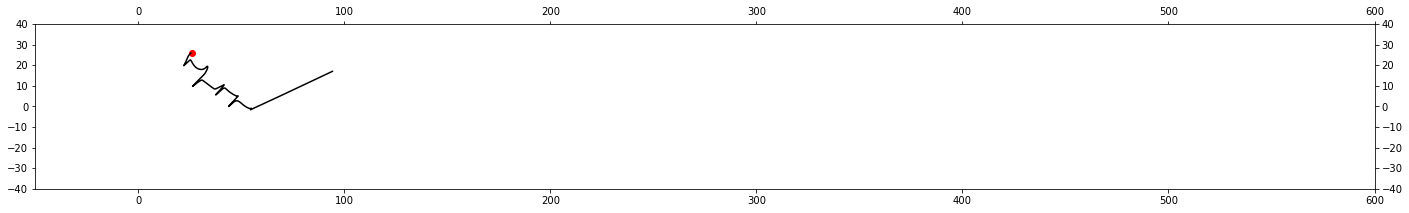

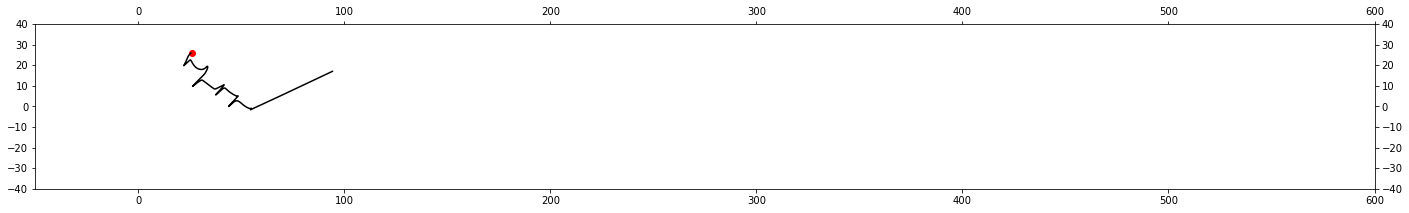

In [48]:
predictions

for threshold in np.arange(0.1, 0.9, 0.1):
    predictions_th = torch.tensor(predictions)
    predictions_th[:, 2] = predictions_th[:, 2] > threshold
    drawing.draw(predictions_th.cpu(), align_strokes=True, denoise_strokes=True)


In [ ]:
def sample(model, predictions):
    with torch.no_grad():
        start = predictions[0]
        for i in range(len(predictions)-1):
            print(model(start.unsqueeze_(0), h0, ).shape()) 
    

In [13]:
class LSTMExp(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMExp, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
    def forward(self, x, h0, c0):
        return self.lstm(x, (h0, c0))
    
input_size = 3
seq_length = 12
hidden_size = 100
batch_size = 10
x = torch.rand(batch_size, seq_length, input_size)
h0 = torch.rand(1, batch_size, hidden_size)
c0 = torch.rand(1, batch_size, hidden_size)
m = LSTMExp(input_size, hidden_size)
out, (hn, cn) = m(x, h0, c0)
print(out.shape)
print(hn.shape)
print(cn.shape)

torch.save({
            'epoch': 2,
            'model_state_dict': m.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': losses[-1],
            }, "model_checkpoints/")

torch.Size([10, 12, 100])
torch.Size([1, 10, 100])
torch.Size([1, 10, 100])


In [46]:
MAX_SEQ_LENGTH = 1200

class HandWritingPrediction(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(HandWritingPrediction, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstmCell1 = nn.LSTMCell(input_size, hidden_size)
        self.lstmCell2 = nn.LSTMCell(hidden_size + input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, input_size)
        self.num_activations = 4 # 2 for each lstm layers
    
    def forward(self, x, activations, idx):
        activations_new[0], activations_new[1] = self.lstmCell1(
            x, (activations_old[0], activations_old[1]))
        activations_new[2], activations_new[3] = self.lstmCell2(
            torch.cat((x, activations_old[2]), 1), (aactivations_old[2], activations_old[3]))
        out = self.linear(activations_old[2])
        return out, activations_old, activations_new
    
    def init_hidden(self, bs, device):
        return torch.zeros(self.num_activations, bs, self.hidden_size).to(device)


In [40]:
def train(model, input_stroke, stroke_len, optimizer, loss_fnc, activations1, activations2):
    optimizer.zero_grad()
    bs = 1
    loss = 0
    for i, pt in enumerate(input_stroke[:stroke_len-1]):
        out, activations = model(pt, activations1, activations2)
        loss += loss_fnc(out, input_stroke[i+1])
    loss = loss/(stroke_len-1)
    loss.backward()
    optimizer.step()
    return loss

In [41]:
def eval(model, input_stroke, stroke_len, loss_fnc, activations):
    with torch.no_grad():
        bs = 1
        loss = 0
        for i, pt in enumerate(input_stroke[:stroke_len-1]):
            out, activations = model(pt, activations, i)
            loss += loss_fnc(out, input_stroke[i+1])
        loss = loss/len(inputs)
        return loss

In [42]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [43]:
batch_size = 1
n_hidden = 1000
n_input = 3

model = HandWritingPrediction(n_input, n_hidden).to(device)
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

    



In [45]:
print_every = 100
n_epochs = 2
n_iters = 0
losses = []
total_loss = 0
activations = model.init_hidden(batch_size, device)

torch.autograd.set_detect_anomaly(True)

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(model, strokes[0].to(device), stroke_lens.item(), optim, loss_function, activations)
        activations.zero_()
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}")
        n_iters += 1

[W python_anomaly_mode.cpp:104] Warning: Error detected in ThnnFusedLstmCellBackward. Traceback of forward call that caused the error:
  File "/home/miniconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/miniconda3/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/miniconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/miniconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/miniconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 667, in start
    self.io_loop.start()
  File "/home/miniconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/miniconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  Fil

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [1, 1000]], which is output 0 of AsStridedBackward, is at version 2049; expected version 2047 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

<Figure size 432x288 with 0 Axes>

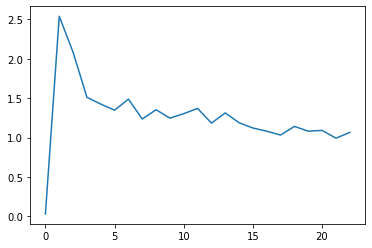

In [38]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses)

In [90]:
from torch.nn.utils.rnn import pack_padded_sequence
s, l = next(iter(train_dataloader))
s.shape
l.shape
#packed = pack_padded_sequence(s, l, batch_first=True, enforce_sorted=False)

#model(packed, h, c)

torch.Size([1, 1200, 3])

torch.Size([1])

In [96]:
eval(model, s[0], l.item(), loss_function)

torch.Size([702, 1, 3])
torch.Size([702, 1, 3])
torch.Size([1, 1000])


tensor(3.1328)